In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('sox_io')

import matplotlib.pyplot as plt
import requests
from utils import *
from wingbeat_datasets import *
from wingbeat_models import *


/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16


In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'wingbeatraw'
normalize = ''#"sample"

fs = 44100

dsname = "twin_cages_experiment/sensorPi/through_entrances_v2"

In [4]:
transforms_list = [FilterWingbeat(setting='bandpass')]#, TransformWingbeat(setting='psd')]

wbdset = WingbeatsDataset(dsname=dsname, clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
psdset = WingbeatsDataset(dsname=dsname, clean=True, verbose=True, transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting='psdl2')]))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)

Found 49 in dataset: twin_cages_experiment/sensorPi/through_entrances_v2, and 1 label(s): ['sensorPi']
No custom label applied.
Found 49 in dataset: twin_cages_experiment/sensorPi/through_entrances_v2, and 1 label(s): ['sensorPi']
No custom label applied.


In [5]:
# plt.plot(wbdset[0][0].T)
# plt.plot(psdset[0][0].T)

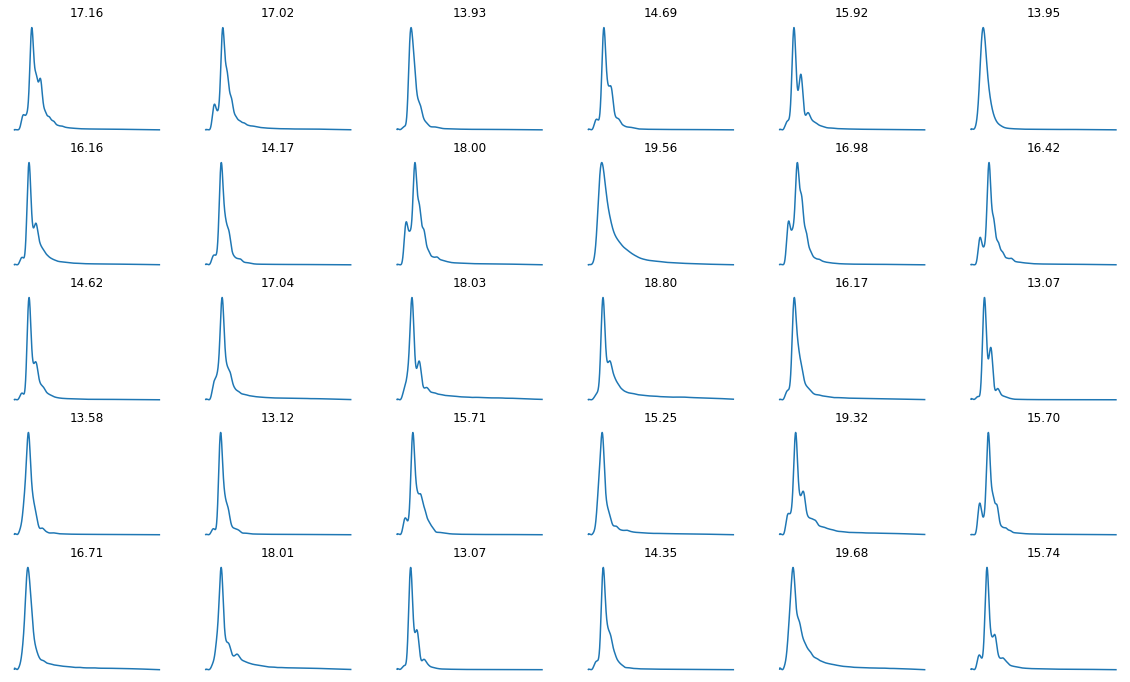

In [6]:
rands = np.random.choice(range(len(wbdset)), len(wbdset), replace=False)

np.random.choice(range(len(wbdset)), len(wbdset), replace=False)

plt.figure(figsize=(20,12))
for i in range(30):
    plt.subplot(5,6,i+1)
    
    sig = psdset[rands[i]][0][0,:1600]
    plt.plot(sig.T)
#     plt.title(f"{psdset.sums[i]:.1f}", y=.6)
    plt.title(f"{sig.sum():.2f}")
    plt.axis('off')

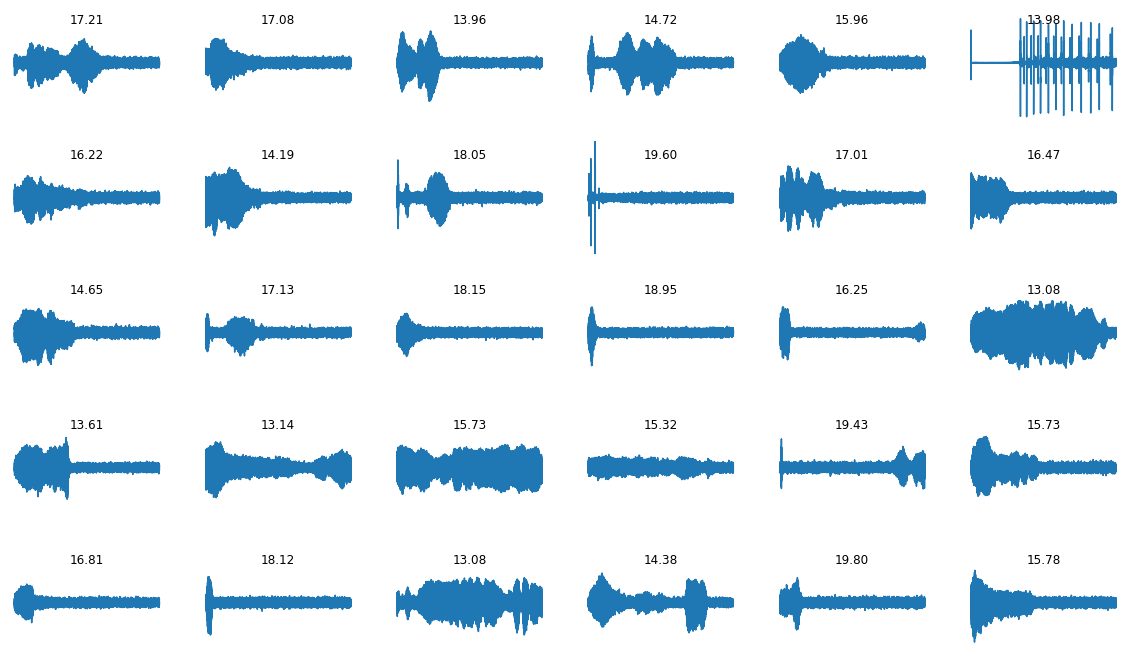

In [7]:
plt.figure(figsize=(20,12))
for i in range(30):
    plt.subplot(5,6,i+1)
    
    sig = wbdset[rands[i]][0]
    plt.plot(sig.T)
    plt.title(f"{wbdset.sums[rands[i]]:.2f}", y=.8)#, absum:{sig.abs().sum():.4f}")
    plt.axis('off')
    plt.ylim(-.065,.065)

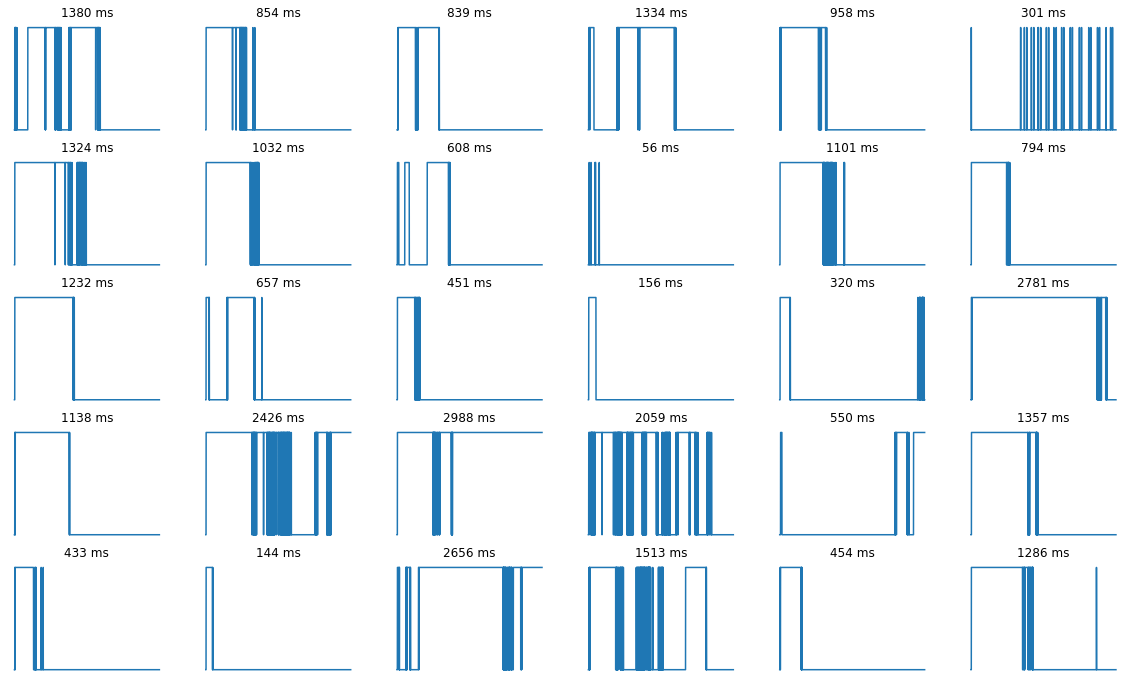

In [8]:
plt.figure(figsize=(20,12))
for i in range(30):
    plt.subplot(5,6,i+1)

    sig = wbdset[rands[i]][0]
    sig = pd.Series(sig.squeeze())
    sig = sig.abs().rolling(250).mean()
    sig = (sig>0.0025).astype(int)
    sig.plot()
    plt.title(f"{wingbeat_duration(sig, rolling_window=250,fs=fs):.0f} ms")
    plt.axis('off')

## Calculate mean flight duration for datasets

In [11]:
wbdset = WingbeatsDataset(dsname="twin_cages_experiment/sensorPi/through_entrances_v1", clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_WBduration_from_loader(dloader, fs=fs)[1:]

Cleaning dataset twin_cages_experiment/sensorPi/through_entrances_v1..	:   0%|          | 0/2 [00:00<?, ?it/s]

Found 55 in dataset: twin_cages_experiment/sensorPi/through_entrances_v1, and 1 label(s): ['sensorPi']


Cleaning dataset twin_cages_experiment/sensorPi/through_entrances_v1..	: 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

Found 19 in dataset: twin_cages_experiment/sensorPi/through_entrances_v1, and 1 label(s): ['sensorPi']
No custom label applied.


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


(793.8990332975294, 589.1609977324263, 615.9523505528944)

In [9]:
wbdset = WingbeatsDataset(dsname="twin_cages_experiment/sensorPi/through_entrances_v2", clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_WBduration_from_loader(dloader, fs=fs)[1:]

  0%|          | 0/2 [00:00<?, ?it/s]

Found 49 in dataset: twin_cages_experiment/sensorPi/through_entrances_v2, and 1 label(s): ['sensorPi']
No custom label applied.


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


(1003.9279929658937, 954.1723356009071, 633.0194470790093)